# ***Neural FCA***

## Initialization

Firstly, let's install all the dependencies

In [63]:
!pip install ucimlrepo

In [64]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

LINK TO DATASET: https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations

This dataset has 120 rows, 5 binary and 1 numerical attributes and 2 target variables.

The main goal of this dataset is to help predict two diseases of urinary system: an acute inflammations of urinary bladder (or cystitis in medical terms) and an acute nephritis. Each instance (a row in the dataset) represents an potential patient.

In [65]:
# Fetch the dataset
acute_inflammations = fetch_ucirepo(id=184)

# Extract features and targets
X = acute_inflammations.data.features
y = acute_inflammations.data.targets

## Binarization strategy

Let's look to dataset's attributes and their values:
1. Temperature of patient - integer value;
2. Occurrence of nausea - "yes" or "no";
3. Lumbar pain - "yes" or "no";
4. Urine pushing (continuous need for urination) - "yes" or "no";
5. Micturition pains - "yes" or "no";
6. Burning of urethra, itch, swelling of urethra outlet - "yes" or "no".

Our targets for binary classification:
1. Inflammation of urinary bladder - "yes" or "no";
2. Nephritis of renal pelvis origin - "yes" or "no".

Primarily let's rename our attributes for better usability.

In [66]:
# Rename columns for better usability
X = X.rename(columns={
    "temperature": "t",
    "nausea": "s1",
    "lumbar-pain": "s2",
    "urine-pushing": "s3",
    "micturition-pains": "s4",
    "burning-urethra": "s5"
})

y = y.rename(columns={
    "bladder-inflammation": "tar1",
    "nephritis": "tar2"
})

# Print the first few rows after renaming
print(X.head())
print(y.head())

      t  s1   s2   s3   s4   s5
0  35.5  no  yes   no   no   no
1  35.9  no   no  yes  yes  yes
2  35.9  no  yes   no   no   no
3  36.0  no   no  yes  yes  yes
4  36.0  no  yes   no   no   no
  tar1 tar2
0   no   no
1  yes   no
2   no   no
3  yes   no
4   no   no


So, now I need to binarize only one attribute, namely "Temperature of patient", let's see its distribution and boundary values.

Min patient temperature = 35.5
Max patient temperature = 41.5



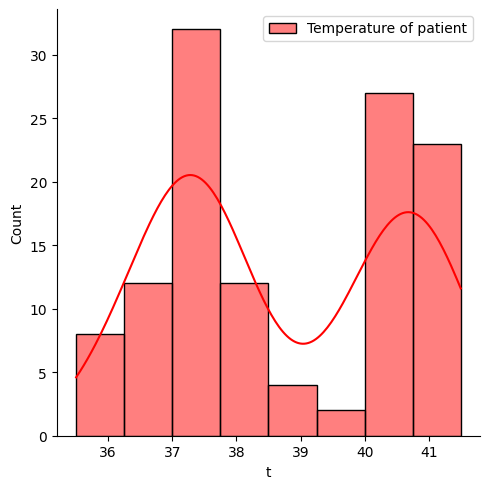

In [67]:
min_temp = min(X['t'])
max_temp = max(X['t'])
print(f"Min patient temperature = {min_temp}\nMax patient temperature = {max_temp}\n")

sns.displot(X['t'], color='red', label="Temperature of patient", kde=True)
plt.legend()
plt.show()

### Binarization of Temperature Data

We see that the temperature readings are mostly between either 37-37.5 degrees or 40-41.5 degrees.

**Threshold Selection:**

- **Threshold:** 38°C
- **Categorization:**
  - **High Temperature:** Temperatures > 38°C
  - **Low Temperature:** Temperatures ≤ 38°C

**Rationale:**

- **Source:** The threshold is based on the World Health Organization (WHO) definition of fever, which considers a temperature above 38°C as indicative of a fever. This provides a legitimate and widely accepted basis for the threshold.
- **Data Distribution:** The data shows a clear distinction around 38°C, with fewer samples around this point, making it a suitable cutoff.


**Conclusion:**

- The chosen threshold of 38°C effectively binarizes the temperature data into high and low categories, aligning with both medical standards and the data distribution.

**Reference:**

- [World Health Organization (WHO) Definition of Fever](https://www.who.int/data/gho/indicator-metadata-registry/imr-details/180)

In [68]:
min_temp = 35.5
max_temp = 41.5
threshold = 38.0

# Create binary categories for temperature
cat_temp = pd.cut(X['t'],
                  bins=[min_temp, threshold, max_temp],
                  labels=['no', 'yes'],
                  right=False)

# Create binary attribute table
X_cat = X[['s1', 's2', 's3', 's4', 's5']].join(cat_temp)

Now Convert 'yes' and 'no' to True and False' for all the attributes and show the final binarized table:

In [69]:
# Convert 'yes' and 'no' to True and False
X_bin = X_cat.copy()

# Iterate over each column in the DataFrame
for col in X_bin.columns:
    # Map 'yes' to True and 'no' to False
    X_bin[col] = X_bin[col].map({'yes': True, 'no': False})

# Convert the entire DataFrame to boolean type
X_bin = X_bin.astype('bool')

Let's now display the binarized attribute table.

In [70]:
s = pd.Series([f'case {i}' for i in range(X.shape[0])])
X_att = X_bin.set_index([s])
X_att.head()

,s1,s2,s3,s4,s5,t
case 0,False,True,False,False,False,False
case 1,False,False,True,True,True,False
case 2,False,True,False,False,False,False
case 3,False,False,True,True,True,False
case 4,False,True,False,False,False,False


Now convert 'yes' and 'no' to True and False' for target **1**

In [71]:
y["tar1"] = y["tar1"].replace(['yes', 'no'], [True, False])
y["tar1"]

<ipython-input-71-6705e36ca5ec>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y["tar1"] = y["tar1"].replace(['yes', 'no'], [True, False])


,tar1
0,False
1,True
2,False
3,True
4,False
...,...
115,False
116,False
117,False
118,False


Now convert 'yes' and 'no' to True and False' for target **2**:

In [72]:
y["tar2"] = y["tar2"].replace(['yes', 'no'], [True, False])
y["tar2"]

<ipython-input-72-70aa463f6b9b>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y["tar2"] = y["tar2"].replace(['yes', 'no'], [True, False])


,tar2
0,False
1,False
2,False
3,False
4,False
...,...
115,True
116,False
117,True
118,True


In [75]:
binarized_data = X_bin.join(y["tar1"]).join(y["tar2"])
binarized_data

,s1,s2,s3,s4,s5,t,tar1,tar2
0,False,True,False,False,False,False,False,False
1,False,False,True,True,True,False,True,False
2,False,True,False,False,False,False,False,False
3,False,False,True,True,True,False,True,False
4,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
115,False,True,True,False,True,True,False,True
116,False,False,False,False,False,NaN,False,False
117,True,True,False,True,False,NaN,False,True
118,False,True,True,False,True,NaN,False,True
